## Data loading

In [1]:
import pandas as pd

In [2]:
x_vals = pd.read_csv("../Data/features.csv", header = 0)
y_vals = pd.read_csv("../Data/Data Determine Y/Zipcode_Yvalues.csv", header = 0, index_col = 0)

In [3]:
y_vals.head()

,Zipcode,Eligible2016,Gentrified2016,Eligible2020,Gentrified2020
1,60601.0,0,0,0,0
2,60602.0,0,0,0,0
3,60603.0,0,0,0,0
4,60604.0,0,0,1,0
5,60605.0,0,0,0,0


In [4]:
y_vals['Zipcode'] = y_vals['Zipcode'].astype('int32')
y_vals = y_vals.rename(columns={'Zipcode': 'zip', 'Gentrified2020':2012})
y_vals = pd.melt(y_vals, id_vars=['zip'], value_vars=[2012], var_name='year')

In [5]:
# Merge datasets and clean data
df = x_vals[x_vals['year'] == 2012].merge(y_vals, how='left', on=['zip', 'year'])
df = df.dropna(axis=1)
df = df.drop(columns=['perc_under_18'])
df = df.iloc[:,2:]

# Change percentages to percentage format
df.college = df.college * 0.01
df.non_hip_white = df.non_hip_white * 0.01
df.vacancy = df.vacancy * 0.01
df.perc_over_65 = df.perc_over_65 * 0.01
df.eviction_rate = df.eviction_rate * 0.01

In [6]:
# Define features and labels
X = df.iloc[:, :12]
y = df.iloc[:, 12]

In [7]:
# Feature variable statistics after transformations
X.describe()

,property_crime,violent_crime,homicide,college,non_hip_white,vacancy,med_rent,perc_over_65,unemp_rate,eviction_rate,gardens,park_area
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,10481.528914,2717.639266,40.382026,0.395242,0.394033,0.147250,1060.017241,0.193822,0.128764,0.018384,0.724138,14.509855
std,6471.561689,2662.755466,47.924665,0.265429,0.289354,0.070940,317.502838,0.118300,0.071903,0.010298,0.450851,25.011043
min,809.693400,58.914900,0.000000,0.060547,0.005805,0.053519,690.000000,0.001558,0.020738,0.003943,0.000000,0.000000
25%,5074.829200,711.849500,4.158100,0.166370,0.097274,0.094473,861.250000,0.120090,0.082117,0.011077,0.000000,3.381782
50%,9929.516900,1640.182700,17.277850,0.344956,0.408271,0.125757,929.000000,0.184023,0.110585,0.016435,1.000000,6.429110
75%,15524.720475,4182.333550,70.069475,0.600502,0.625932,0.180582,1109.500000,0.268113,0.167104,0.023348,1.000000,13.232485
max,23338.244400,8625.991900,141.520900,0.895145,0.867348,0.388759,1923.000000,0.529480,0.345020,0.050545,1.000000,131.852813


## Data pre-processing

In [8]:
import sklearn
import sklearn.model_selection
from sklearn.preprocessing import RobustScaler

In [9]:
# Scale features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
# Split into train and test sets
rndm_state = 999
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
                                    X_scaled, y,
                                    train_size=0.75,
                                    random_state=rndm_state)

## Model 1: Neural Net

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
torch.manual_seed(999)

In [12]:
# Create PyTorch dataset and dataloader
training_X = torch.FloatTensor(X_train)
training_y = torch.FloatTensor(y_train.to_numpy())
train_ds = TensorDataset(training_X, training_y)
batch_size = 1
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [13]:
# Create sequential neural network model
model = nn.Sequential(
    nn.Linear(12, 24),
    nn.ReLU(),
    nn.Linear(24, 24),
    nn.ReLU(),
    nn.Linear(24, 1))

In [14]:
# Define loss function and SGD optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [15]:
# Define training function
# Idea for logging of loss an accuracies taken from:
# Raschka, Liu, and Mirjalili - "Machine Learning with PyTorch and Scikit-Learn"

def train(model, num_epochs, epoch_log, train_dl, X_test, y_test):
    loss_train = [0] * num_epochs
    acc_train = [0] * num_epochs
    loss_valid = [0] * num_epochs
    acc_valid = [0] * num_epochs
    
    for epoch in range(num_epochs):
        loss_log = 0
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_train[epoch] += loss.item()
            pred_correct = ((pred>=0.5).float() == y_batch).float()
            acc_train[epoch] += pred_correct.mean()
        
        # Report training loss and accuracies
        loss_train[epoch] /= len(train_dl)
        acc_train[epoch] /= len(train_dl)
        if epoch % epoch_log == 0:
            print(f"Epoch {epoch} loss :", loss_train[epoch])
        
        # Report testing loss and accuracies
        pred = model(X_test)[:, 0]
        loss = loss_fn(pred, y_test)
        loss_valid[epoch] = loss.item()
        pred_correct = ((pred>=0.5).float() == y_test).float()
        acc_valid[epoch] = pred_correct.mean()
        
    return loss_train, acc_train, loss_valid, acc_valid            

#### Model training and testing

In [16]:
import matplotlib.pyplot as plt

In [17]:
testing_X = torch.FloatTensor(X_test)
testing_y = torch.FloatTensor(y_test.to_numpy())

In [18]:
epochs = 1000
print_every = 100
history = train(model, epochs, print_every, train_dl, testing_X, testing_y)

Epoch 0 loss : 0.7924423689065978
Epoch 100 loss : 0.4012682410173638
Epoch 200 loss : 0.32961134037522727
Epoch 300 loss : 0.28321264466835283
Epoch 400 loss : 0.2511363002492946
Epoch 500 loss : 0.22658704910865565
Epoch 600 loss : 0.2076840292126457
Epoch 700 loss : 0.19228260149797607
Epoch 800 loss : 0.17926380050665375
Epoch 900 loss : 0.16716724069317


Text(0.5, 0, 'Epochs')

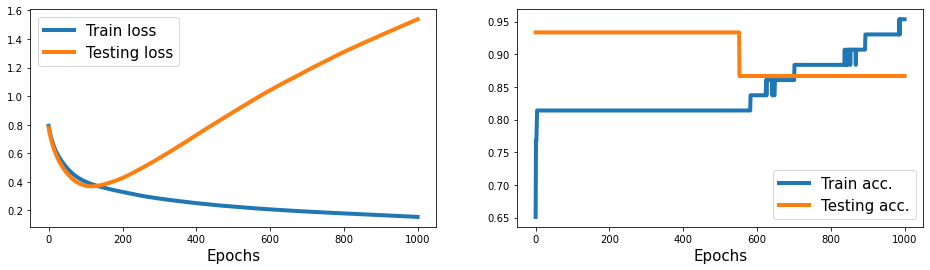

In [19]:
# Create plots for loss and accuracy
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[2], lw=4)
plt.legend(['Train loss', 'Testing loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 2, 2)
plt.plot(history[1], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Testing acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

In [20]:
with torch.no_grad():
    pred = model(testing_X)[:, 0]
    loss = loss_fn(pred, testing_y)
    print(f"Test MSE: ", loss.item())

Test MSE:  1.5382912158966064


In [ ]:
# Note: the model is over-fitting a lot, as shown by testing results in plot